In [426]:
API_ID = "b9ed413b-68c7-487f-bea8-81887a538521"

In [427]:
import requests
import json

# URL de destino
url = f"https://picota.io/api/1.0.0/digital-twin/{API_ID}/subject/hogar02/inference"

# Payload correspondiente a TU LÍNEA DE DATOS
payload = {
    "instant": "2006-01-04T08:00:00Z",
    "capitalProvincia": False,
    "tamanoMunicipio": 1,
    "densidad": 1,
    "superficie": 100.0,
    "tipoCasa": 2,
    "aguaCaliente": True,
    "calefaccion": True,
    "zonaResidencial": 1,
    "regimenTenencia": 6,
    "comidasTotales": 93.0,
    "miembros:estudiantes": 0,
    "miembros:noEstudiantes": 3,
    "miembros:ocupados": 3.0,
    "miembros:noOcupados": 0,
    "miembros:activos": 3.0,
    "miembros:noActivos": 0,
    "miembros:ancianos:masculinos": 0,
    "miembros:ancianos:femeninos": 0,
    "miembros:adultos:masculinos": 0,
    "miembros:adultos:femeninos": 0,
    "miembros:ninos:masculinos": 3,
    "miembros:ninos:femeninos": 0,
    "miembros:conIngresos:masculinos": 0,
    "miembros:conIngresos:femeninos": 3,
    "miembros:sinIngresos:masculinos": 0,
    "miembros:sinIngresos:femeninos": 0,
    "edadSp": 53,
    "espanolSp": True,
    "educacionSuperiorSp": False,
    "fuentePrincipalIngresos": "asalariado",
    "numeroViviendasAdicionales": 0.0,
    "ingresosNetos": 15137.979169629054,
    "gastoNoMonetario": 2708.796581882706,
    "tasaAhorro": -0.5249852042764415,
    "temperaturaMedia": 15.33,
    "tasaParo": 5.5,
    "inflacion": 2.9,
    "España.tipoInteres": 3.5,
    "España.tasaCambioEurUsd": 1.26,
    "ipc": 80.99066666666666,
    "gastoMonetario:productosAlimenticios11": 4313.269202252849,
    "gastoMonetario:bebidasNoAlcoholicas12": 577.3196952793096,
    "gastoMonetario:bebidasAlcoholicas21": 354.324950581223,
    "gastoMonetario:tabaco22": 423.45447744978486,
    "gastoMonetario:articulosDeVestir31": 2030.051270154727,
    "gastoMonetario:calzado32": 908.7628302676465,
    "gastoMonetario:alquileresRealesDeLaVivienda41": 0.0650256837183378,
    "gastoMonetario:mantenimientoDeLaVivienda43": 1.437790117772137,
    "gastoMonetario:suministroDeAgua44": 82.68376938585094,
    "gastoMonetario:electricidadGasOtrosCombustibles45": 711.091976839868,
    "gastoMonetario:mueblesRevestimientos51": 5.707810015276324,
    "gastoMonetario:textilesParaElHogar52": 1.603966865052334,
    "gastoMonetario:grandesElectrodomesticos53": 484.87484825973934,
    "gastoMonetario:utensiliosDelHogar54": 16.45149798073948,
    "gastoMonetario:herramientasCasaJardin55": 5.491057736215197,
    "gastoMonetario:bienesServiciosParaElHogar56": 350.3583838744044,
    "gastoMonetario:productosFarmaceuticos61": 1562.4154531563158,
    "gastoMonetario:serviciosMedicosAmbulatorios62": 1826.679831787641,
    "gastoMonetario:serviciosHospitalarios63": 1019.8544246433344,
    "gastoMonetario:compraDeVehiculos71": 1.119886775149152,
    "gastoMonetario:usoDeVehiculosPersonales72": 2065.562518540908,
    "gastoMonetario:serviciosDeTransporte73": 156.20614244338495,
    "gastoMonetario:serviciosPostales81": 7.521304083421079,
    "gastoMonetario:equiposTelefonoFax82": 22.56391225026324,
    "gastoMonetario:serviciosTelefonoFax83": 625.5687525983163,
    "gastoMonetario:audiovisualesTecnologia91": 232.49571959693267,
    "gastoMonetario:bienesDuraderosDeOcio92": 30.69212271505547,
    "gastoMonetario:ocioJardineriaYMascotas93": 112.19097964203893,
    "gastoMonetario:serviciosRecreativosYCulturales94": 366.7231809435194,
    "gastoMonetario:prensaYPapeleria95": 271.0776252698131,
    "gastoMonetario:paquetesTuristicos96": 0.5635559255589281,
    "gastoMonetario:educacionInfantilYPrimaria101": 0.0144501519374084,
    "gastoMonetario:educacionSecundariaYPostsecundaria102": 0.0,
    "gastoMonetario:educacionSuperior103": 0.1445015193740841,
    "gastoMonetario:educacionNoFormal104": 0.036125379843521,
    "gastoMonetario:restauracion111": 2503.4815980800386,
    "gastoMonetario:alojamiento112": 0.2312024309985346,
    "gastoMonetario:cuidadosPersonales121": 1842.582223994759,
    "gastoMonetario:efectosPersonales123": 858.9892819192431,
    "gastoMonetario:proteccionSocial124": 0.0216752279061126,
    "gastoMonetario:seguros125": 287.3846217311785,
    "gastoMonetario:serviciosFinancieros126": 0.0,
    "gastoMonetario:otrosServicios127": 3.431911085134498,
    "gastoMonetario:remesas128": 40.547126336368
}



# Cabeceras
headers = {
    "Content-Type": "application/json"
}

# Enviar petición
response = requests.post(url, headers=headers, data=json.dumps(payload))

print("Código de respuesta:", response.status_code)
try:
    print("Respuesta del servidor:", response.json())
except Exception as e:
    print("Error interpretando JSON:", response.text)


Código de respuesta: 200
Respuesta del servidor: [{'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:productosAlimenticios11', 'value': 3781.4709969718756}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:bebidasNoAlcoholicas12', 'value': 192.45199004642663}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:bebidasAlcoholicas21', 'value': 107.58682738652146}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:tabaco22', 'value': 703.9355678625849}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:articulosDeVestir31', 'value': 2009.4708640140245}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:calzado32', 'value': 487.8483557992974}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:alquileresRealesDeLaVivienda41', 'value': 145.4587759065546}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:mantenimientoDeLaVivienda43', 'value': 322.1553032690448}, {'subject': 

In [312]:
# 1. Envía payload original → pred_base
response_base = requests.post(url, headers=headers, data=json.dumps(payload))
print("Base:", response_base.json())

# 2. Modifica payload
payload_modificado = payload.copy()
payload_modificado["miembros:ninos:masculinos"] += 1
payload_modificado["miembros:sinIngresos:masculinos"] += 1
payload_modificado["miembros:noEstudiantes"] += 1
payload_modificado["miembros:noOcupados"] += 1
payload_modificado["miembros:noActivos"] += 1
payload_modificado["comidasTotales"] += 56
payload_modificado["ingresosNetos"] += 1500

response_escenario = requests.post(url, headers=headers, data=json.dumps(payload_modificado))
print("Escenario aumentado:", response_escenario.json())


Base: [{'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:productosAlimenticios11', 'value': 7050.533867968947}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:bebidasNoAlcoholicas12', 'value': 557.4341677859644}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:bebidasAlcoholicas21', 'value': 333.65055211652066}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:tabaco22', 'value': 449.67480107555474}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:articulosDeVestir31', 'value': 1111.3499626374755}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:calzado32', 'value': 633.9278789317932}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:alquileresRealesDeLaVivienda41', 'value': 7968.083712523801}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoMonetario:mantenimientoDeLaVivienda43', 'value': 637.0308960039737}, {'subject': 'main_49_4_02034268504', 'variable': 'gastoM

### Simulacion caso de uso IRPF

In [449]:
import pandas as pd
import os

In [450]:
df_tax_2025 = pd.read_csv('../../datamarts/tax_datamart_2025.tsv', sep='\t')

df_tax_2025.head()

,code,iva,igic,ipsi
0,11,11,4.0,2.0
1,12,10,7.0,0.5
2,21,21,13.5,10.0
3,22,21,20.0,10.0
4,31,21,3.0,4.0


In [451]:
df_inference_errors = pd.read_csv('../../datamarts/inference_errors.tsv', sep='\t', index_col=0)

df_inference_errors.head()

,productosAlimenticios11,bebidasNoAlcoholicas12,bebidasAlcoholicas21,tabaco22,articulosDeVestir31,calzado32,alquileresRealesDeLaVivienda41,mantenimientoDeLaVivienda43,suministroDeAgua44,electricidadGasOtrosCombustibles45,mueblesRevestimientos51,textilesParaElHogar52,grandesElectrodomesticos53,utensiliosDelHogar54,herramientasCasaJardin55,bienesServiciosParaElHogar56,productosFarmaceuticos61,serviciosMedicosAmbulatorios62,serviciosHospitalarios63,compraDeVehiculos71,usoDeVehiculosPersonales72,serviciosDeTransporte73,serviciosPostales81,equiposTelefonoFax82,serviciosTelefonoFax83,audiovisualesTecnologia91,bienesDuraderosDeOcio92,ocioJardineriaYMascotas93,serviciosRecreativosYCulturales94,prensaYPapeleria95,paquetesTuristicos96,educacionInfantilYPrimaria101,educacionSecundariaYPostsecundaria102,educacionSuperior103,educacionNoFormal104,restauracion111,alojamiento112,cuidadosPersonales121,efectosPersonales123,proteccionSocial124,seguros125,serviciosFinancieros126,otrosServicios127,remesas128
subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
hogar01,2.76,2.42,0.47,1.44,1.36,2.21,0.86,0.65,0.44,2.72,0.52,0.61,1.42,0.56,0.37,0.62,1.24,0.47,0.12,1.55,2.12,1.46,0.10,1.19,2.56,1.54,0.10,0.67,0.32,0.75,0.89,0.48,0.50,0.70,0.35,1.96,0.98,1.26,0.18,0.37,0.80,0.63,0.06,0.15
hogar02,4.29,2.43,1.50,3.81,1.16,2.49,2.15,0.87,2.18,3.32,1.22,0.94,2.62,0.48,0.39,1.37,1.36,1.36,0.06,1.92,2.68,2.18,0.14,2.42,5.03,2.37,0.23,1.05,1.61,1.15,1.86,0.67,0.47,0.66,0.68,2.92,2.38,2.19,0.48,0.92,1.78,1.80,0.15,0.74
hogar03,3.37,2.85,1.80,2.59,2.49,3.67,2.07,0.70,0.64,1.51,1.30,0.54,1.58,0.29,0.61,1.65,1.85,0.78,0.10,2.28,2.70,1.47,0.16,2.38,3.48,1.20,0.30,1.01,0.97,1.42,2.01,0.39,0.56,0.61,0.21,1.89,0.97,1.52,0.51,0.90,0.84,2.64,0.07,0.76
hogar04,3.51,3.10,1.64,4.42,1.53,3.40,1.91,0.76,1.42,3.82,0.54,0.76,2.07,0.63,0.67,1.82,1.72,1.10,0.10,2.95,2.24,3.18,0.52,2.10,4.52,1.34,0.08,0.74,1.23,0.68,1.25,1.16,0.72,0.56,0.98,2.11,1.35,3.68,0.26,0.96,2.85,2.03,0.27,0.53
hogar05,4.68,4.50,2.11,1.95,1.47,2.88,1.98,1.19,0.72,4.14,1.37,0.67,2.35,0.55,0.73,0.86,1.32,0.52,0.15,1.98,2.36,1.69,0.14,1.34,2.05,0.87,0.08,0.96,1.94,1.80,1.20,0.96,0.89,0.82,0.63,2.23,1.46,3.25,0.48,0.62,1.28,2.35,0.18,0.42


In [452]:
bool_cols = [
    'capitalProvincia', 'aguaCaliente', 'calefaccion', 
    'espanolSp', 'educacionSuperiorSp'
]

In [453]:
import os
import pandas as pd

def leer_datos_ccaa(ccaa, ruta_tsvs):
    """
    Lee el archivo hogar{ccaa}.tsv del directorio dado y devuelve 
    solo las filas del año 2023 (filtradas por timestamp).

    Parameters
    ----------
    ccaa : str o int
        Código de dos dígitos de la CCAA (e.g. "01" o 1).
    ruta_tsvs : str
        Ruta al directorio donde se encuentran los archivos .tsv.

    Returns
    -------
    pd.DataFrame
        DataFrame con los datos de hogares de la CCAA para el año 2023.
        Si no existe el archivo o no hay datos de 2023, retorna DataFrame vacío.
    """
    ccaa_str = f"{int(ccaa):02d}"  # Formatear código a dos dígitos
    nombre_archivo = f"hogar{ccaa_str}.tsv"
    ruta_archivo = os.path.join(ruta_tsvs, nombre_archivo)
    
    if not os.path.exists(ruta_archivo):
        print(f"⚠️ Archivo no encontrado: {nombre_archivo}")
        return pd.DataFrame()  # DataFrame vacío si no existe el archivo
    
    print(f"✅ Leyendo archivo: {nombre_archivo}")
    df = pd.read_csv(ruta_archivo, sep='\t')
    if "timestamp" in df.columns:
        # Filtrar filas cuyo timestamp comienza con "2023"
        mask = df["timestamp"].astype(str).str.startswith("2023")
        df = df[mask]
        # Resetear índice para que los hogares estén indexados de 0 a n-1
        df = df.reset_index(drop=True)
    else:
        print(f"⚠️ Columna 'timestamp' no encontrada en {nombre_archivo}. Devolviendo datos sin filtrar por año.")
    
    return df


In [454]:
import numpy as np

def generar_nuevos_hijos(df, escenario_probs):
    """
    Genera aleatoriamente cuántos hijos nacen en cada hogar (0 a 3) 
    y asigna sexo (masculino/femenino) para cada nuevo hijo,
    utilizando las probabilidades específicas del escenario.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de hogares (una fila por hogar).
    escenario_probs : dict
        Diccionario con probabilidades de tener 0, 1, 2, 3 hijos.
        Ejemplo: {0: 0.5, 1: 0.3, 2: 0.15, 3: 0.05}

    Returns
    -------
    incrementos_m : np.ndarray
        Array con el número de hijos masculinos nuevos por hogar.
    incrementos_f : np.ndarray
        Array con el número de hijos femeninos nuevos por hogar.
    hijos_nuevos : np.ndarray
        Array con el total de hijos nuevos por hogar.
    """
    num_hogares = len(df)
    posibles_hijos = [0, 1, 2, 3]
    
    # Validar que las probabilidades sumen 1
    probs = np.array([escenario_probs.get(x, 0.0) for x in posibles_hijos])
    if not np.isclose(probs.sum(), 1.0):
        raise ValueError("Las probabilidades del escenario no suman 1.")
    
    incrementos_m = np.zeros(num_hogares, dtype=int)
    incrementos_f = np.zeros(num_hogares, dtype=int)
    hijos_nuevos = np.zeros(num_hogares, dtype=int)

    for i in range(num_hogares):
        # Elegir número de nuevos hijos según escenario
        n = np.random.choice(posibles_hijos, p=probs)
        hijos_nuevos[i] = n
        # Asignar sexo a cada nuevo hijo
        for _ in range(n):
            if np.random.rand() < 0.5:
                incrementos_m[i] += 1
            else:
                incrementos_f[i] += 1

    return incrementos_m, incrementos_f, hijos_nuevos


In [455]:
def aplicar_deducciones_hijos(df, incrementos_m, incrementos_f, hijos_nuevos, importes_deduccion):
    """
    Aplica al DataFrame original los incrementos de miembros por nuevos hijos 
    y las deducciones fiscales en los ingresos netos, según el número de hijos nuevos.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame original de hogares.
    incrementos_m : np.ndarray
        Número de hijos masculinos nuevos por hogar.
    incrementos_f : np.ndarray
        Número de hijos femeninos nuevos por hogar.
    hijos_nuevos : np.ndarray
        Número total de hijos nuevos por hogar.
    importes_deduccion : dict
        Diccionario que mapea número de hijos nuevos -> importe de deducción (€) en ese hogar.

    Returns
    -------
    df_modificado : pd.DataFrame
        DataFrame con los campos actualizados tras los nuevos hijos y deducciones.
    total_incremento_euros : float
        Importe total (no ponderado) añadido a `ingresosNetos` en todos los hogares.
    incremento_por_hogar : np.ndarray
        Array de importes de deducción añadidos a `ingresosNetos` por cada hogar.
    """
    df_modificado = df.copy()
    # Incrementar conteo de niños en el hogar
    df_modificado["miembros:ninos:masculinos"] += incrementos_m
    df_modificado["miembros:ninos:femeninos"] += incrementos_f
    # Añadir esos miembros como personas sin ingresos (dependientes)
    df_modificado["miembros:sinIngresos:masculinos"] += incrementos_m
    df_modificado["miembros:sinIngresos:femeninos"] += incrementos_f
    # Incrementar también en las categorías de no estudiantes, no ocupados, no activos
    nuevos_miembros = incrementos_m + incrementos_f  # total nuevos miembros por hogar
    df_modificado["miembros:noEstudiantes"] += nuevos_miembros
    df_modificado["miembros:noOcupados"] += nuevos_miembros
    df_modificado["miembros:noActivos"] += nuevos_miembros
    # Calcular deducción fiscal por hogar según número de hijos nuevos
    incremento_por_hogar = np.array([importes_deduccion.get(int(n), 0.0) for n in hijos_nuevos], dtype=float)
    # Sumar deducción a los ingresos netos de cada hogar
    df_modificado["ingresosNetos"] += incremento_por_hogar
    # Aumentar comidas totales (20 comidas más por cada hijo nuevo, p. ej. comidas mensuales)
    df_modificado["comidasTotales"] += (hijos_nuevos * 20)
    # Calcular total invertido (suma no ponderada de todas las deducciones aplicadas)
    total_incremento_euros = float(incremento_por_hogar.sum())
    return df_modificado, total_incremento_euros, incremento_por_hogar


In [456]:
import requests
import json
from time import sleep

def inferir_gastos_hogares(df, columnas_booleanas, ccaa, api_id, delay=0):
    """
    Envía los datos de cada hogar a la API de inferencia para predecir sus gastos monetarios.
    Retorna un DataFrame con una fila por hogar y columnas de predicción de gasto por categoría.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame con los datos de los hogares a predecir (una fila por hogar).
    columnas_booleanas : list of str
        Lista de nombres de columnas que deben tratarse como booleanas al enviar a la API.
    ccaa : str
        Código de la comunidad autónoma (dos dígitos como cadena, e.g. "01").
    api_id : str
        ID de la API del digital twin a la que se hacen las peticiones.
    delay : int, optional
        Tiempo de espera (segundos) entre peticiones para no sobrecargar la API.

    Returns
    -------
    pd.DataFrame
        DataFrame con predicciones de gastos. Índice: `hogar` (ID del hogar), 
        Columnas: variables de gasto monetario, más (opcionalmente) columnas auxiliares.
    """
    url = f"https://picota.io/api/1.0.0/digital-twin/{api_id}/subject/hogar{ccaa}/inference"
    lista_preds = []  # Para acumular predicciones por hogar
    
    # Determinar columnas a enviar (omitimos la columna factor y otras no relevantes para la predicción)
    cols_enviar = [col for col in df.columns if col != "factor"]
    
    for i, row in df[cols_enviar].iterrows():
        payload = row.to_dict()
        # Convertir columnas booleanas a tipo bool en el payload
        for col in columnas_booleanas:
            if col in payload:
                valor = payload[col]
                # Si viene como string ("True"/"False"), convertir 
                payload[col] = (str(valor).lower() == "true") if isinstance(valor, str) else bool(valor)
        # Renombrar campo de tiempo para la API
        if "timestamp" in payload:
            payload["instant"] = payload.pop("timestamp")
        else:
            # Si no hay timestamp, igualmente definimos "instant" con algún valor temporal único
            payload["instant"] = f"hogar{ccaa}-row{i}"
        # Enviar petición
        try:
            response = requests.post(url, headers={"Content-Type": "application/json"}, data=json.dumps(payload))
        except Exception as e:
            print(f"⚠️ Error de conexión al inferir hogar {i} (CCAA {ccaa}): {e}")
            continue
        # Controlar respuesta de la API
        if response.status_code != 200:
            print(f"⚠️ Respuesta {response.status_code} inferiendo hogar {i} (CCAA {ccaa}): {response.text}")
            continue
        try:
            pred = response.json()
        except json.JSONDecodeError:
            print(f"⚠️ Respuesta no es JSON válido para hogar {i}: {response.text}")
            continue
        if not pred:
            # Si la API devuelve un cuerpo vacío o nulo
            print(f"⚠️ Sin predicciones para hogar {i} (CCAA {ccaa}).")
            continue
        # Convertir la lista de predicciones en DataFrame
        df_pred = pd.DataFrame(pred)
        # Añadir identificador del hogar para poder pivotar
        df_pred["hogar"] = i
        lista_preds.append(df_pred)
        # Esperar un momento antes de la siguiente petición (si se especificó delay)
        if delay:
            sleep(delay)
    
    if not lista_preds:
        return pd.DataFrame()  # Si ninguna predicción fue exitosa
    
    # Concatenar todas las predicciones y pivotar para obtener una fila por hogar
    df_preds_total = pd.concat(lista_preds, ignore_index=True)
    df_wide = df_preds_total.pivot_table(index="hogar", columns="variable", values="value")
    # Asegurar que el índice "hogar" está en orden ascendente (coincide con df original) 
    # y sin índices faltantes (por si algún hogar no tuvo predicción, rellenar con NaN)
    df_wide = df_wide.reindex(range(len(df)), fill_value=np.nan)
    # Añadir columna de subject (identificador del dataset/hogar) para referencias futuras
    df_wide["subject"] = f"hogar{ccaa}"
    return df_wide


In [457]:
import re

def calcular_recaudacion_fiscal(diferencia_gastos, ccaa_codigo, df_impuestos):
    """
    Calcula la recaudación fiscal adicional a partir de un incremento de gasto por categorías.

    Parameters
    ----------
    diferencia_gastos : pd.Series o pd.DataFrame (una fila)
        Incremento de gasto monetario por categoría (los nombres de índice o columnas contienen códigos numéricos de categoría al final).
    ccaa_codigo : str o int
        Código de la CCAA para determinar el impuesto aplicable:
        - '18' → Ceuta (IPSI)
        - '19' → Melilla (IPSI)
        - '05' → Canarias (IGIC)
        - Otro  → Península/Baleares (IVA)
    df_impuestos : pd.DataFrame
        DataFrame con columnas ['code', 'iva', 'igic', 'ipsi'] donde cada fila es una categoría de gasto con su tipo impositivo.

    Returns
    -------
    float
        Importe total de recaudación fiscal adicional derivada del incremento de gasto.
    """
    # Asegurar ccaa como cadena de dos dígitos
    ccaa_str = str(ccaa_codigo).zfill(2)
    # Elegir columna de impuesto según CCAA
    if ccaa_str in ['18', '19']:
        col_impuesto = "ipsi"
    elif ccaa_str == '05':
        col_impuesto = "igic"
    else:
        col_impuesto = "iva"
    # Si se pasa un DataFrame, tomar la primera fila como serie de diferencias
    if isinstance(diferencia_gastos, pd.DataFrame):
        if diferencia_gastos.empty:
            return 0.0
        diff_series = diferencia_gastos.iloc[0]
    elif isinstance(diferencia_gastos, pd.Series):
        diff_series = diferencia_gastos
    else:
        # Si es dict u otro iterable, convertir a Series
        diff_series = pd.Series(diferencia_gastos)
    total_recaudacion = 0.0
    for categoria, aumento in diff_series.items():
        # Extraer código numérico de la categoría (últimos dígitos del nombre)
        match = re.search(r"(\d+)$", str(categoria))
        if not match:
            continue  # Si no hay código numérico al final, pasar al siguiente
        codigo = int(match.group(1))
        fila_impuesto = df_impuestos[df_impuestos["code"] == codigo]
        if fila_impuesto.empty:
            continue  # Código no encontrado en tabla de impuestos
        tasa = float(fila_impuesto[col_impuesto].values[0])
        if tasa > 0:
            # Sumar recaudación: aumento de gasto * tasa de impuesto (%)
            total_recaudacion += (aumento * tasa / 100.0)
    return total_recaudacion


In [552]:
def simular_escenarios_deducciones(lista_ccaa, ruta_datos, columnas_booleanas, df_impuestos, escenarios_deduccion, escenario_probs, api_id, df_errors):
    """
    Ejecuta la simulación de escenarios de deducción fiscal por nuevos hijos para varias CCAA, 
    manteniendo el mismo incremento de hijos por CCAA en todos sus escenarios.

    Parameters
    ----------
    lista_ccaa : list
        Lista de códigos de CCAA a procesar (ejemplo: ["01", "02", ..., "19"]).
    ruta_datos : str
        Directorio donde se encuentran los archivos hogarXX.tsv de las CCAA.
    columnas_booleanas : list of str
        Columnas que deben tratarse como booleanas al inferir gastos.
    df_impuestos : pd.DataFrame
        Tabla de tipos impositivos por categoría (columnas: 'code', 'iva', 'igic', 'ipsi').
    escenarios_deduccion : dict
        Diccionario de escenarios a simular. Formato:
        {"nombre_escenario": {0: importe0, 1: importe1, 2: importe2, 3: importe3}, ...}
        donde el sub-diccionario indica la deducción en € para 0,1,2,3 hijos nuevos respectivamente.
    api_id : str
        ID de la API de inferencia a utilizar.
    df_errors : pd.DataFrame
        DataFrame de errores de inferencia (%) por categoría. Índice: 'subject' (ej. "hogar05"), 
        Columnas: nombres de categoría de gasto (sin prefijo "gastoMonetario:").

    Returns
    -------
    df_resumen : pd.DataFrame
        Resumen nacional con una fila por escenario y columnas:
        ['escenario', 'dinero_invertido', 'recaudacion_min', 'recaudacion_media', 'recaudacion_max'].
    df_diferencias_categorias : pd.DataFrame
        DataFrame con aumento de gasto (medio) por categoría a nivel nacional.
        Columnas: ['escenario', 'categoria', 'gasto_incrementado'].
    """
    resultados_escenarios = []           # Para filas del resumen nacional
    lista_dif_categorias = []           # Para diferencias de gasto por categoría (por CCAA y escenario)

    # Acumuladores nacionales inicializados en 0 para cada escenario
    totales_inversion = {esc: 0.0 for esc in escenarios_deduccion}
    totales_recaudacion_med = {esc: 0.0 for esc in escenarios_deduccion}
    totales_recaudacion_min = {esc: 0.0 for esc in escenarios_deduccion}
    totales_recaudacion_max = {esc: 0.0 for esc in escenarios_deduccion}

    for ccaa in lista_ccaa:
        ccaa_str = f"{int(ccaa):02d}"
        subject_id = f"hogar{ccaa_str}"
        print(f"\n▶️ Procesando CCAA {ccaa_str}...")
        # 1. Leer datos originales de la CCAA      
        df = leer_datos_ccaa(ccaa_str, ruta_datos)
        if df.empty:
            print(f"⚠️ Sin datos para CCAA {ccaa_str}, se omite.")
            continue
        print(f"   Hogares cargados: {len(df)}")
        
        

        # 4. Iterar sobre cada escenario de deducción
        for nombre_esc, importes in escenarios_deduccion.items():
            print(f"      ➡️ Escenario: {nombre_esc}")

            # --- NUEVO: generar hijos con las probabilidades del escenario ---
            probs = escenario_probs.get(nombre_esc)
            if probs is None:
                raise ValueError(f"No se han definido probabilidades de natalidad para el escenario: {nombre_esc}")
            
            incrementos_m, incrementos_f, nuevos_hijos = generar_nuevos_hijos(df, probs)
            print(f"         Hijos nuevos generados por hogar: {nuevos_hijos}")

            if nuevos_hijos.sum() == 0:
                print(f"         ➡️ No se han generado hijos nuevos en este escenario. Se omite el escenario {nombre_esc} para CCAA {ccaa_str}.")
                continue

            # Filtrar solo hogares con incremento de hijos
            indices_hogares_con_hijos = np.where(nuevos_hijos > 0)[0]

            if len(indices_hogares_con_hijos) == 0:
                print(f"         ➡️ Ningún hogar individual tuvo nuevos hijos. Se omite el escenario {nombre_esc} para CCAA {ccaa_str}.")
                continue

            # Filtrar df y vectores para procesar solo hogares relevantes
            df_filtrado = df.iloc[indices_hogares_con_hijos].copy()
            incrementos_m_filtrado = incrementos_m[indices_hogares_con_hijos]
            incrementos_f_filtrado = incrementos_f[indices_hogares_con_hijos]
            nuevos_hijos_filtrado = nuevos_hijos[indices_hogares_con_hijos]



            # 2. Predicción base de gastos para cada hogar
            df_pred_base = inferir_gastos_hogares(df_filtrado, columnas_booleanas, ccaa_str, api_id)
            if df_pred_base.empty:
                print(f"⚠️ No se obtuvieron predicciones base para CCAA {ccaa_str}, se omite.")
                continue
            print(f"   Predicciones base obtenidas (hogares: {df_pred_base.shape[0]}, categorías: {df_pred_base.shape[1]-1})")
            
            # --- lo demás queda igual ---
            df_esc, total_incremento, incremento_por_hogar = aplicar_deducciones_hijos(
                df_filtrado, incrementos_m_filtrado, incrementos_f_filtrado, nuevos_hijos_filtrado, importes
            )


            # Calcular dinero invertido ponderado por factor (expansión muestral)
            dinero_invertido_factorizado = float((incremento_por_hogar * df_filtrado["factor"].values).sum())
            totales_inversion[nombre_esc] += dinero_invertido_factorizado
            print(f"         Dinero invertido total (ponderado): {dinero_invertido_factorizado:,.2f} €")

            # 4.2 Predicción de gastos en el escenario
            df_pred_esc = inferir_gastos_hogares(df_esc, columnas_booleanas, ccaa_str, api_id)
            if df_pred_esc.empty:
                print(f"         ⚠️ Predicciones vacías en escenario {nombre_esc} (CCAA {ccaa_str}). Se omite este escenario para esta CCAA.")
                continue

            # 4.3 Calcular gasto total (ponderado) por categoría en base y escenario
            # Seleccionar solo columnas numéricas (gasto) y eliminar columnas auxiliares ('subject' y cualquier no numérico)
            cols_gasto = [col for col in df_pred_base.columns if col != "subject"]
            df_pred_base_num = df_pred_base[cols_gasto].astype(float, errors='ignore')
            df_pred_esc_num = df_pred_esc[cols_gasto].astype(float, errors='ignore')

            # Calcular totales ponderados (multiplicar fila por factor del hogar y sumar)
            gastos_base_totales = df_pred_base_num.multiply(df["factor"], axis=0).sum()
            gastos_esc_totales = df_pred_esc_num.multiply(df["factor"], axis=0).sum()

            # 4.4 Aplicar errores de inferencia para obtener mínimo y máximo de gasto total por categoría
            if subject_id in df_errors.index:
                error_series = df_errors.loc[subject_id]

                # Asegurar que índices de error tienen mismo formato que columnas de gasto (prefijo "gastoMonetario:")
                error_series_pref = error_series.copy()
                error_series_pref.index = error_series_pref.index.map(lambda x: f"gastoMonetario:{x}")
            else:
                # Si no se tiene registro de error para esta CCAA, asumimos 0% error en todas las categorías
                error_series_pref = pd.Series(0.0, index=gastos_esc_totales.index)
                print(f"         ⚠️ Errores de inferencia no encontrados para {subject_id}. Se asume 0% error.")

            # Calcular escenarios de gasto mínimo y máximo totales por categoría
            gastos_esc_totales_min = gastos_esc_totales * (1 - error_series_pref/100.0)
            gastos_esc_totales_max = gastos_esc_totales * (1 + error_series_pref/100.0)

            # 4.5 Diferencias de gasto por categoría (escenario - base) para media, min, max
            dif_gasto_media = gastos_esc_totales - gastos_base_totales
            dif_gasto_min = gastos_esc_totales_min - gastos_base_totales
            dif_gasto_max = gastos_esc_totales_max - gastos_base_totales

            # 4.6 Calcular recaudación fiscal adicional (media, min, max) por el incremento de gasto
            recaudacion_media = calcular_recaudacion_fiscal(dif_gasto_media, ccaa_str, df_impuestos)
            recaudacion_min = calcular_recaudacion_fiscal(dif_gasto_min, ccaa_str, df_impuestos)
            recaudacion_max = calcular_recaudacion_fiscal(dif_gasto_max, ccaa_str, df_impuestos)

            # Acumular recaudaciones nacionales
            totales_recaudacion_med[nombre_esc] += recaudacion_media
            totales_recaudacion_min[nombre_esc] += recaudacion_min
            totales_recaudacion_max[nombre_esc] += recaudacion_max

            print(f"         Recaudación adicional (media): {recaudacion_media:,.2f} €  (min: {recaudacion_min:,.2f} €, max: {recaudacion_max:,.2f} €)")

            # 4.7 Acumular diferencia de gasto por categoría (valor medio) para análisis nacional por categorías
            df_dif_media = pd.DataFrame([dif_gasto_media])
            dif_long = df_dif_media.T.reset_index()
            dif_long.columns = ["categoria", "gasto_incrementado"]
            
            # Añadir identificadores de escenario y CCAA
            dif_long["escenario"] = nombre_esc
            dif_long["ccaa"] = ccaa_str
            lista_dif_categorias.append(dif_long)

    # 5. Consolidar resultados nacionales
    print("\n✅ RESULTADOS NACIONALES:")
    for esc in escenarios_deduccion.keys():
        inv_total = totales_inversion[esc]
        rec_min_total = totales_recaudacion_min[esc]
        rec_med_total = totales_recaudacion_med[esc]
        rec_max_total = totales_recaudacion_max[esc]
        print(f"   Escenario {esc}: Inversión {inv_total:,.2f} € → Recaudación [min={rec_min_total:,.2f} €, media={rec_med_total:,.2f} €, max={rec_max_total:,.2f} €]")
        resultados_escenarios.append({
            "escenario": esc,
            "dinero_invertido": inv_total,
            "recaudacion_min": rec_min_total,
            "recaudacion_media": rec_med_total,
            "recaudacion_max": rec_max_total
        })

    df_resumen = pd.DataFrame(resultados_escenarios)

    # 6. Agrupar diferencias de gasto por categoría a nivel nacional (sumar todas las CCAA)
    if lista_dif_categorias:
        df_diferencias_categorias = pd.concat(lista_dif_categorias, ignore_index=True)
        df_diferencias_categorias = df_diferencias_categorias.groupby(["escenario", "categoria"], as_index=False).agg({"gasto_incrementado": "sum"})
    else:
        df_diferencias_categorias = pd.DataFrame(columns=["escenario", "categoria", "gasto_incrementado"])

    print("🏁 Simulación completada.")
    return df_resumen, df_diferencias_categorias


In [553]:
escenarios_deduccion = {
    "austero":   {0: 0,    1: 0,    2: 1200,   3: 2400},
    "moderado":  {0: 0,    1: 2500, 2: 5000,   3: 8000},
    "generoso":  {0: 0,    1: 3000, 2: 8000,   3: 15000},
    "muy_generoso": {0: 0, 1: 5000, 2: 15000,  3: 25000}
}

escenario_probs = {
    "austero": {
        0: 0.95,   # 95% de familias no tienen hijos ese año
        1: 0.045,  # 4,5% tiene 1 hijo
        2: 0.004,  # 0,4% tiene 2 hijos (gemelos)
        3: 0.001   # 0,1% tiene 3 hijos (trillizos)
    },
    "moderado": {
        0: 0.90,
        1: 0.085,
        2: 0.012,
        3: 0.003
    },
    "generoso": {
        0: 0.80,
        1: 0.17,
        2: 0.025,
        3: 0.005
    },
    "muy_generoso": {
        0: 0.70,
        1: 0.25,
        2: 0.04,
        3: 0.01
    }
}


In [555]:
df_esp1, df_dif_cat_esp1 = simular_escenarios_deducciones(
    lista_ccaa=["01"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 01...
✅ Leyendo archivo: hogar01.tsv
   Hogares cargados: 2186
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 ... 0 0 0]
   Predicciones base obtenidas (hogares: 93, categorías: 44)
         Dinero invertido total (ponderado): 9,891,201.31 €
         Recaudación adicional (media): -10,993.97 €  (min: -198,745.54 €, max: 176,757.59 €)
      ➡️ Escenario: moderado
         Hijos nuevos generados por hogar: [0 1 0 ... 0 0 0]
   Predicciones base obtenidas (hogares: 185, categorías: 44)
         Dinero invertido total (ponderado): 720,198,115.10 €
         Recaudación adicional (media): 8,179,549.06 €  (min: 6,775,914.53 €, max: 9,583,183.59 €)
      ➡️ Escenario: generoso
         Hijos nuevos generados por hogar: [0 0 0 ... 0 0 0]
   Predicciones base obtenidas (hogares: 456, categorías: 44)
         Dinero invertido total (ponderado): 2,393,255,017.73 €
         Recaudación adicional (media): 55,700,976.20 €  (min: 46,730,107.02 €, max:

In [556]:
df_esp2, df_dif_cat_esp2 = simular_escenarios_deducciones(
    lista_ccaa=["02"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 02...
✅ Leyendo archivo: hogar02.tsv
   Hogares cargados: 762
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

In [557]:
df_esp3, df_dif_cat_esp3 = simular_escenarios_deducciones(
    lista_ccaa=["03"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 03...
✅ Leyendo archivo: hogar03.tsv
   Hogares cargados: 915
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0 2 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0

In [554]:
df_esp4, df_dif_cat_esp4 = simular_escenarios_deducciones(
    lista_ccaa=["04"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 04...
✅ Leyendo archivo: hogar04.tsv
   Hogares cargados: 402
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 2 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
   Predicciones base obtenidas 

In [558]:
df_esp5, df_dif_cat_esp5 = simular_escenarios_deducciones(
    lista_ccaa=["05"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 05...
✅ Leyendo archivo: hogar05.tsv
   Hogares cargados: 911
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0

In [ ]:
df_esp6, df_dif_cat_esp6 = simular_escenarios_deducciones(
    lista_ccaa=["06"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 06...
✅ Leyendo archivo: hogar06.tsv
   Hogares cargados: 798
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0

In [ ]:
df_esp7, df_dif_cat_esp7 = simular_escenarios_deducciones(
    lista_ccaa=["07"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 07...
✅ Leyendo archivo: hogar07.tsv
   Hogares cargados: 1266
   Predicciones base obtenidas (hogares: 1266, categorías: 44)
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [1 0 0 ... 0 0 0]
         Dinero invertido total (ponderado): 116,987,711.05 €
         Recaudación adicional (media): 29,763,872.45 €  (min: -28,521,949.42 €, max: 88,049,694.33 €)
      ➡️ Escenario: moderado
         Hijos nuevos generados por hogar: [2 0 0 ... 0 0 0]
         Dinero invertido total (ponderado): 531,979,621.30 €
         Recaudación adicional (media): 90,632,258.56 €  (min: 31,181,314.37 €, max: 150,083,202.75 €)
      ➡️ Escenario: generoso
         Hijos nuevos generados por hogar: [0 0 1 ... 0 1 0]
         Dinero invertido total (ponderado): 1,762,488,551.72 €
         Recaudación adicional (media): 239,974,518.91 €  (min: 177,875,481.50 €, max: 302,073,556.32 €)

✅ RESULTADOS NACIONALES:
   Escenario austero: Inversión 116,987,711.05 € → Recaudaci

In [ ]:
df_esp8, df_dif_cat_esp8 = simular_escenarios_deducciones(
    lista_ccaa=["08"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 08...
✅ Leyendo archivo: hogar08.tsv
   Hogares cargados: 1024
   Predicciones base obtenidas (hogares: 1024, categorías: 44)
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 ... 0 0 0]
         Dinero invertido total (ponderado): 96,209,980.22 €
         Recaudación adicional (media): 22,891,172.65 €  (min: -38,073,883.60 €, max: 83,856,228.90 €)
      ➡️ Escenario: moderado
         Hijos nuevos generados por hogar: [0 1 0 ... 0 2 0]
         Dinero invertido total (ponderado): 490,164,334.55 €
         Recaudación adicional (media): 82,608,281.34 €  (min: 20,204,645.69 €, max: 145,011,916.98 €)
      ➡️ Escenario: generoso
         Hijos nuevos generados por hogar: [2 0 0 ... 0 1 1]
         Dinero invertido total (ponderado): 1,379,585,858.94 €
         Recaudación adicional (media): 183,220,153.31 €  (min: 118,620,996.21 €, max: 247,819,310.41 €)

✅ RESULTADOS NACIONALES:
   Escenario austero: Inversión 96,209,980.22 € → Recaudación

In [ ]:
df_esp9, df_dif_cat_esp9 = simular_escenarios_deducciones(
    lista_ccaa=["09"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 09...
✅ Leyendo archivo: hogar09.tsv
   Hogares cargados: 1516
   Predicciones base obtenidas (hogares: 1516, categorías: 44)
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 0 0 ... 0 0 0]
         Dinero invertido total (ponderado): 377,694,818.56 €
         Recaudación adicional (media): 52,323,104.93 €  (min: -147,774,785.59 €, max: 252,420,995.44 €)
      ➡️ Escenario: moderado
         Hijos nuevos generados por hogar: [2 0 0 ... 1 0 0]
         Dinero invertido total (ponderado): 1,732,967,372.08 €
         Recaudación adicional (media): 192,515,144.47 €  (min: -10,190,576.51 €, max: 395,220,865.45 €)
      ➡️ Escenario: generoso
         Hijos nuevos generados por hogar: [1 1 0 ... 0 0 1]
         Dinero invertido total (ponderado): 5,172,443,122.14 €
         Recaudación adicional (media): 517,655,821.20 €  (min: 308,746,763.50 €, max: 726,564,878.89 €)

✅ RESULTADOS NACIONALES:
   Escenario austero: Inversión 377,694,818.56 € → Rec

In [ ]:
df_esp10, df_dif_cat_esp10 = simular_escenarios_deducciones(
    lista_ccaa=["10"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
df_esp11, df_dif_cat_esp11 = simular_escenarios_deducciones(
    lista_ccaa=["11"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)


▶️ Procesando CCAA 11...
✅ Leyendo archivo: hogar11.tsv
   Hogares cargados: 915
   Predicciones base obtenidas (hogares: 915, categorías: 44)
      ➡️ Escenario: austero
         Hijos nuevos generados por hogar: [0 1 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 2 0 0 1 0 0 1 0 2 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 

KeyboardInterrupt: 

In [ ]:
df_esp12, df_dif_cat_esp12 = simular_escenarios_deducciones(
    lista_ccaa=["12"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
df_esp13, df_dif_cat_esp13 = simular_escenarios_deducciones(
    lista_ccaa=["13"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
df_esp14, df_dif_cat_esp14 = simular_escenarios_deducciones(
    lista_ccaa=["14"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
df_esp15, df_dif_cat_esp15 = simular_escenarios_deducciones(
    lista_ccaa=["15"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
df_esp16, df_dif_cat_esp16 = simular_escenarios_deducciones(
    lista_ccaa=["16" , "17", "18", "19"], 
    ruta_datos="../../datamarts/irpfData",
    columnas_booleanas=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios_deduccion,
    escenario_probs=escenario_probs,
    api_id=API_ID,
    df_errors=df_inference_errors
)

In [ ]:
dfs_dif = [df_dif_cat_esp1, df_dif_cat_esp2, df_dif_cat_esp3, df_dif_cat_esp4,
           df_dif_cat_esp5, df_dif_cat_esp6, df_dif_cat_esp7, df_dif_cat_esp8,
           df_dif_cat_esp9, df_dif_cat_esp10, df_dif_cat_esp11, df_dif_cat_esp12,
           df_dif_cat_esp13, df_dif_cat_esp14, df_dif_cat_esp15, df_dif_cat_esp16]

# Une todos los DataFrames en uno solo
df_total = pd.concat(dfs_dif, ignore_index=True)

# Agrupar y sumar
df_dif_cat_esp = df_total.groupby(
    ["escenario", "categoria"], as_index=False
)["gasto_incrementado"].sum()

# Opcional: redondear para mejor lectura
df_dif_cat_esp["gasto_incrementado"] = df_dif_cat_esp["gasto_incrementado"].round(2)


In [ ]:
df_dif_cat_esp

,escenario,categoria,gasto_incrementado
0,austero,gastoMonetario:alojamiento112,-27504186.59
1,austero,gastoMonetario:alquileresRealesDeLaVivienda41,2031385.22
2,austero,gastoMonetario:articulosDeVestir31,76438148.22
3,austero,gastoMonetario:audiovisualesTecnologia91,-1127816.76
4,austero,gastoMonetario:bebidasAlcoholicas21,-7759314.92
...,...,...,...
127,moderado,gastoMonetario:suministroDeAgua44,2636802.08
128,moderado,gastoMonetario:tabaco22,7355754.81
129,moderado,gastoMonetario:textilesParaElHogar52,-2159779.43
130,moderado,gastoMonetario:usoDeVehiculosPersonales72,-18946700.76


In [ ]:
dfs = [df_esp1, df_esp2, df_esp3, df_esp4, df_esp5, df_esp6, df_esp7, df_esp8, df_esp9, df_esp10, df_esp11, df_esp12, df_esp13, df_esp14, df_esp15, df_esp16]


df_total = pd.concat(dfs)

# agrupar por escenario y sumar el resto de columnas
df_esp = df_total.groupby("escenario").sum()


In [ ]:
# ordenar index por primero austero, luego moderado, luego generoso
df_esp = df_esp.reindex(
    ["austero", "moderado", "generoso"], 
    axis=0
)

# quitar escenario de indice y ponerlo como columna
df_esp = df_esp.reset_index()

In [ ]:
df_esp

,escenario,dinero_invertido,recaudacion_min,recaudacion_media,recaudacion_max
0,austero,1.769004e+08,-9.536288e+07,4.114966e+07,1.776622e+08
1,moderado,7.666692e+08,-1.168387e+07,1.274725e+08,2.666289e+08
2,generoso,2.446084e+09,1.609466e+08,3.051158e+08,4.492849e+08


In [ ]:
import numpy as np
import pandas as pd

def resumen_recaudacion(df_resumen):
    """
    Genera una tabla resumen con % de recaudación sobre dinero invertido
    para recaudación mínima, media y máxima.

    Parameters
    ----------
    df_resumen : pd.DataFrame

    Returns
    -------
    pd.DataFrame
        Tabla resumen legible.
    """
    df = df_resumen.copy()

    # Calcular % para cada tipo de recaudación
    for col in ["recaudacion_min", "recaudacion_media", "recaudacion_max"]:
        pct_col = f"porcentaje_{col}"
        df[pct_col] = np.where(
            df["dinero_invertido"] != 0,
            (df[col] / df["dinero_invertido"]) * 100,
            np.nan
        )
        df[pct_col] = df[pct_col].round(2)
        df[col] = df[col].round(2)

    df["dinero_invertido"] = df["dinero_invertido"].round(2)

    cols_final = [
        "escenario",
        "dinero_invertido",
        "recaudacion_min", "porcentaje_recaudacion_min",
        "recaudacion_media", "porcentaje_recaudacion_media",
        "recaudacion_max", "porcentaje_recaudacion_max"
    ]

    df_final = df[cols_final]

    return df_final


In [ ]:
resumen_df = resumen_recaudacion(df_esp)

In [ ]:
resumen_df

,escenario,dinero_invertido,recaudacion_min,porcentaje_recaudacion_min,recaudacion_media,porcentaje_recaudacion_media,recaudacion_max,porcentaje_recaudacion_max
0,austero,1.769004e+08,-9.536288e+07,-53.91,4.114966e+07,23.26,1.776622e+08,100.43
1,moderado,7.666692e+08,-1.168387e+07,-1.52,1.274725e+08,16.63,2.666289e+08,34.78
2,generoso,2.446084e+09,1.609466e+08,6.58,3.051158e+08,12.47,4.492849e+08,18.37


In [ ]:
import matplotlib.pyplot as plt

def plot_recaudacion_vs_inversion(df_resumen):
    """
    Dibuja la banda de incertidumbre en azul intenso
    y una línea negra con la recaudación media.
    """
    plt.figure(figsize=(8,5))
    
    x = df_resumen["dinero_invertido"]
    
    if {"recaudacion_min", "recaudacion_max", "recaudacion_media"}.issubset(df_resumen.columns):
        y_min = df_resumen["recaudacion_min"]
        y_max = df_resumen["recaudacion_max"]
        y_media = df_resumen["recaudacion_media"]

        # Banda de incertidumbre
        plt.fill_between(
            x,
            y_min,
            y_max,
            color="royalblue",
            alpha=1.0,
            label="Rango de incertidumbre"
        )

        # Línea de recaudación media
        plt.plot(
            x,
            y_media,
            color="black",
            linewidth=2,
            marker="o",
            label="Recaudación media"
        )

    plt.xlabel("Importe del Incentivo Fiscal (€)")
    plt.ylabel("Recaudación Indirecta Estimada (€)")
    plt.title("Análisis de Retorno Fiscal Indirecto por Deducciones IRPF")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


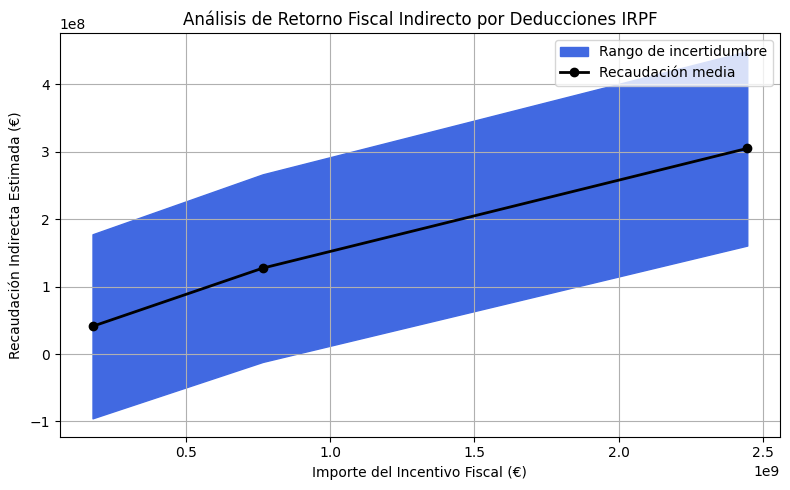

In [ ]:
plot_recaudacion_vs_inversion(resumen_df)

In [ ]:
import matplotlib.pyplot as plt

def plot_recaudacion_pct_vs_inversion(df_resumen):
    """
    Dibuja la banda de incertidumbre y la línea media,
    mostrando la recaudación en % sobre la inversión.
    """
    plt.figure(figsize=(8,5))

    x = df_resumen["dinero_invertido"]

    if {"recaudacion_min", "recaudacion_max", "recaudacion_media"}.issubset(df_resumen.columns):
        y_min_pct = 100 * df_resumen["recaudacion_min"] / x
        y_max_pct = 100 * df_resumen["recaudacion_max"] / x
        y_media_pct = 100 * df_resumen["recaudacion_media"] / x

        # Banda de incertidumbre
        plt.fill_between(
            x,
            y_min_pct,
            y_max_pct,
            color="royalblue",
            alpha=0.7,
            label="Rango de incertidumbre (%)"
        )

        # Línea media
        plt.plot(
            x,
            y_media_pct,
            color="black",
            linewidth=2,
            label="Recaudación media (%)"
        )

    plt.xlabel("Importe del Incentivo Fiscal (€)")
    plt.ylabel("Recaudación sobre inversión (%)")
    plt.title("Retorno Fiscal sobre Inversión - Deducciones IRPF")
    plt.legend()
    plt.grid(True, ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()


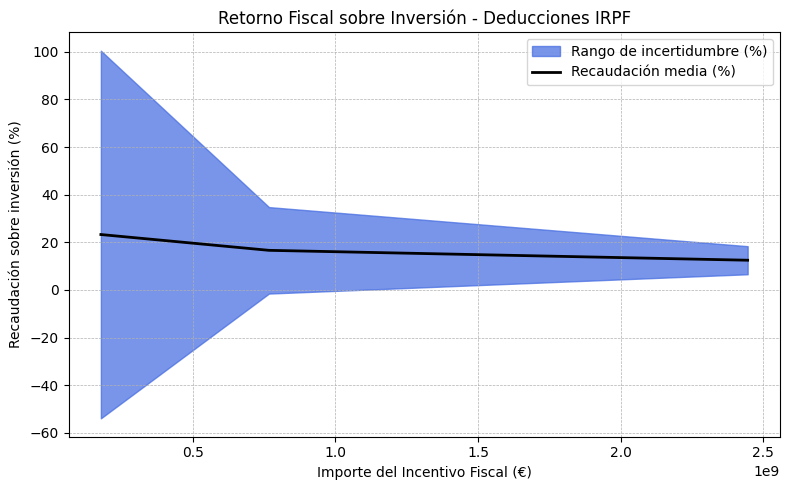

In [ ]:
plot_recaudacion_pct_vs_inversion(df_esp)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_diferencias_por_categoria(
    df_dif_categorias,
    top_n=60,
    figsize=(15,10),
    ordenar=True
):
    """
    Grafica la diferencia de gasto por categoría y escenario.

    Parameters
    ----------
    df_dif_categorias : pd.DataFrame
        DataFrame con columnas:
        - 'escenario'
        - 'categoria'
        - 'gasto_incrementado'

    top_n : int
        Número de categorías más relevantes a mostrar (por suma absoluta de diferencias).
        Si None, muestra todas.

    figsize : tuple
        Tamaño del gráfico (anchura, altura).

    ordenar : bool
        Si True, ordena las barras por magnitud del gasto incremental.

    Returns
    -------
    None
    """
    # Filtrar solo gastoMonetario
    df_plot = df_dif_categorias[
        df_dif_categorias["categoria"].str.startswith("gastoMonetario:")
    ].copy()

    # Quitar prefijo
    df_plot["categoria_simple"] = df_plot["categoria"].str.replace(
        "gastoMonetario:", "", regex=False
    )

    # Seleccionar solo top_n categorías
    if top_n is not None:
        suma_abs = (
            df_plot
            .groupby("categoria_simple")
            .agg(total_abs=("gasto_incrementado", lambda x: x.abs().sum()))
            .reset_index()
            .sort_values("total_abs", ascending=False)
        )
        categorias_top = suma_abs.head(top_n)["categoria_simple"].tolist()
        df_plot = df_plot[df_plot["categoria_simple"].isin(categorias_top)]

    # Ordenar si se indica
    if ordenar:
        orden_categorias = (
            df_plot
            .groupby("categoria_simple")["gasto_incrementado"]
            .sum()
            .sort_values(ascending=False)
            .index
        )
    else:
        orden_categorias = None

    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_plot,
        x="categoria_simple",
        y="gasto_incrementado",
        hue="escenario",
        order=orden_categorias
    )
    plt.xticks(rotation=90)
    plt.ylabel("Variación del gasto (€)")
    plt.title("Diferencia de gasto por categoría y escenario")
    plt.tight_layout()
    plt.show()


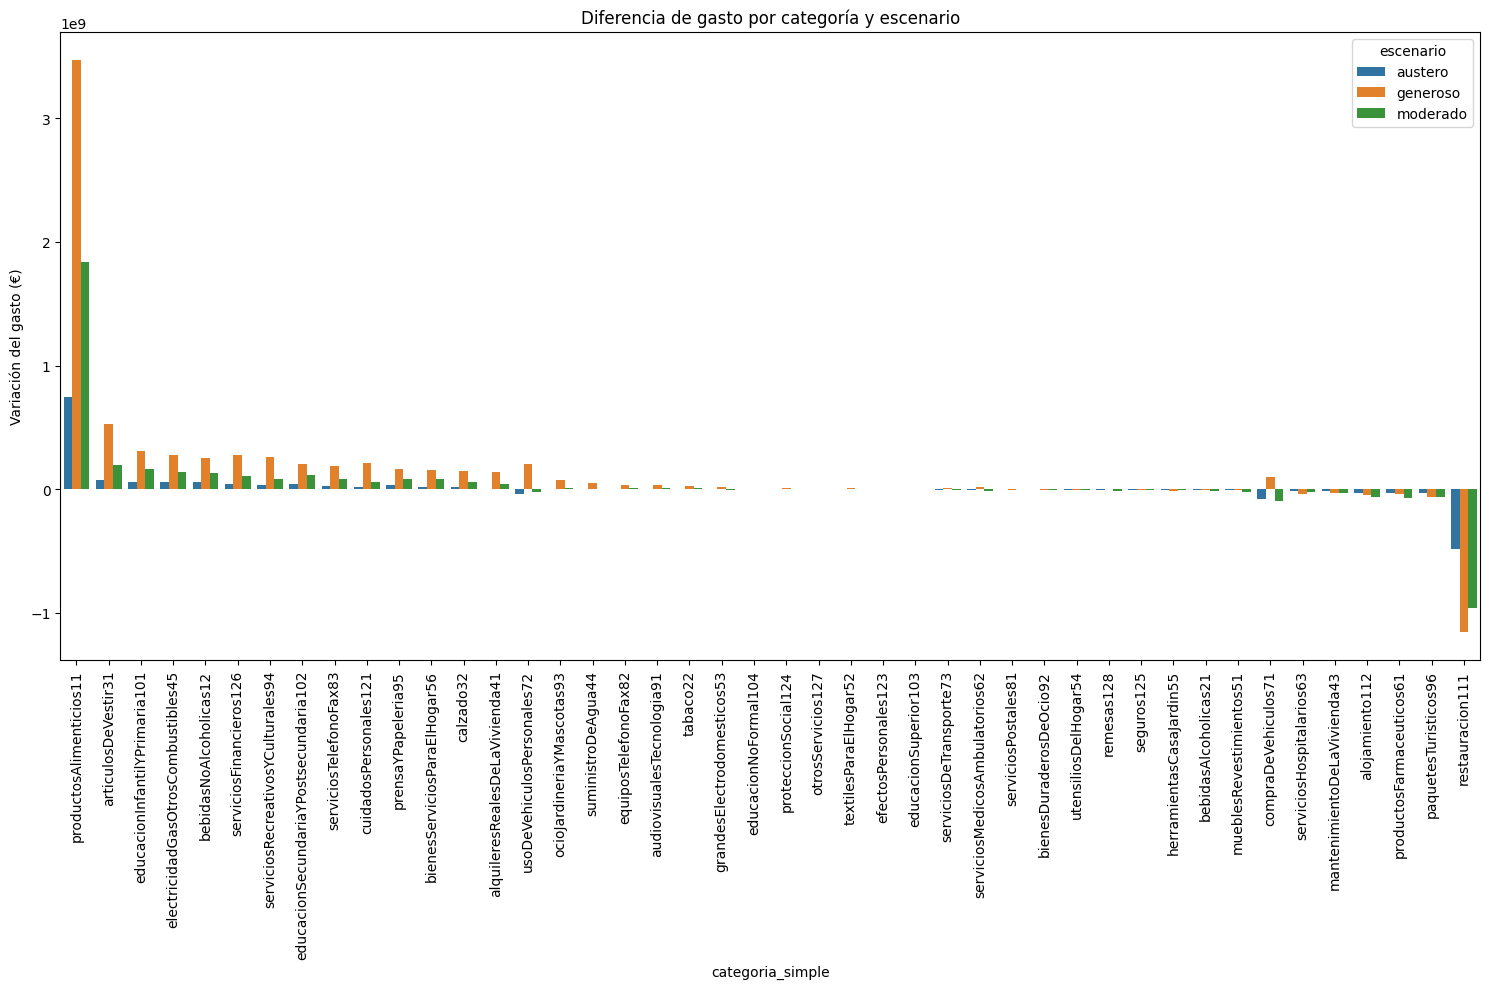

In [ ]:
graficar_diferencias_por_categoria(
    df_dif_cat_esp)